# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('drive/My Drive/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 10000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (10000, 10)


Id  ...                                               Text
0   1  ...  I have bought several of the Vitality canned d...
1   2  ...  Product arrived labeled as Jumbo Salted Peanut...
2   3  ...  This is a confection that has been around a fe...

[3 rows x 10 columns]

In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


UserId  ... COUNT(*)
0  #oc-R115TNMSPFT9I7  ...        2
1  #oc-R11D9D7SHXIJB9  ...        3
2  #oc-R11DNU2NBKQ23Z  ...        2
3  #oc-R11O5J5ZVQE25C  ...        3
4  #oc-R12KPBODL2B5ZD  ...        2

[5 rows x 7 columns]

In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId  ... COUNT(*)
80638  AZY10LLTJ71NX  ...        5

[1 rows x 7 columns]

In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id  ...                                               Text
0   78445  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1  138317  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2  138277  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3   73791  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4  155049  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

[5 rows x 10 columns]

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(9564, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

95.64

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id  ...                                               Text
0  64422  ...  My son loves spaghetti so I didn't hesitate or...
1  44737  ...  It was almost a 'love at first bite' - the per...

[2 rows x 10 columns]

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(9564, 10)


1    7976
0    1588
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
15 month old loves to eat them on the go! They seem great for a healthy, quick, and easy snack!
These chips are truly amazing. They have it all. They're light, crisp, great tasting, nice texture, AND they're all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and couldn't belive my taste buds. That's why I excited why I saw them here on Amazon, and decided to buy a case!
These tablets definitely made things sweeter -- like lemons, limes, and grapefruit.  But it wasn't to the point of sheer amazement.  They also had an interesting effect on cheeses and vinegar, but still did virtually nothing for beer and wine. The tablets are a bit pricey but they do work.  If you've got extra money, sure, give them a try, but if you're looking for some amazing way to get your kids to eat broccoli or something along those lines then this is not the answer. F

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
15 month old loves to eat them on the go! They seem great for a healthy, quick, and easy snack!
These chips are truly amazing. They have it all. They're light, crisp, great tasting, nice texture, AND they're all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and couldn't belive my taste buds. That's why I excited why I saw them here on Amazon, and decided to buy a case!
These tablets definitely made things sweeter -- like lemons, limes, and grapefruit.  But it wasn't to the point of sheer amazement.  They also had an interesting effect on cheeses and vinegar, but still did virtually nothing for beer and wine. The tablets are a bit pricey but they do work.  If you've got extra money, sure, give them a try, but if you're looking for some amazing way to get your kids to eat broccoli or something along those lines then this is not the answer. F

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

These chips are truly amazing. They have it all. They are light, crisp, great tasting, nice texture, AND they are all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and could not belive my taste buds. That is why I excited why I saw them here on Amazon, and decided to buy a case!


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

These chips are truly amazing They have it all They are light crisp great tasting nice texture AND they are all natural AND low in fat and sodium Need I say more I recently bought a bag of them at a regular grocery store and could not belive my taste buds That is why I excited why I saw them here on Amazon and decided to buy a case 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 9564/9564 [00:03<00:00, 3048.56it/s]


In [0]:
preprocessed_reviews[1500]

'chips truly amazing light crisp great tasting nice texture natural low fat sodium need say recently bought bag regular grocery store could not belive taste buds excited saw amazon decided buy case'

#### Train-Test Split

In [0]:
from sklearn.model_selection import train_test_split

X = preprocessed_reviews[:]
y = final['Score'][:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(X_train)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaaa', 'aahhhs', 'ab', 'aback', 'abandon', 'abberline', 'abbott', 'abby', 'abdominal']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (6694, 15387)
the number of unique words  15387


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(X_train)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (6694, 4122)
the number of unique words including both unigrams and bigrams  4122


In [0]:
X_test1 = count_vect.transform(X_test)

### Elbow method

Text(0.5, 1.0, 'K vs Inertia')

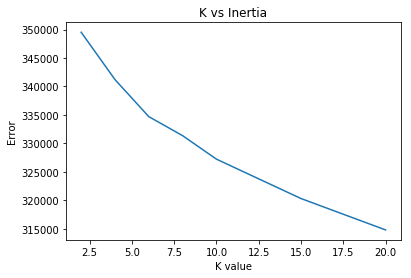

In [0]:
from sklearn.cluster import KMeans

errors=[]
k =[2,4,6,8,10,15,20]
for i in k :
    kmeans = KMeans(n_clusters=i, random_state=42, n_jobs=-1,verbose=5)
    kmeans.fit(final_bigram_counts)
    pred=kmeans.predict(X_test1)
    errors.append(kmeans.inertia_)
    
plt.plot(k, errors)
plt.xlabel("K value")
plt.ylabel("Error")
plt.title("K vs Inertia")

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
model = KMeans(n_clusters=20, n_jobs=-1)
bow_data = count_vect.fit_transform(preprocessed_reviews)

model.fit(scaler.fit_transform(bow_data.toarray()))

labels = model.labels_

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>


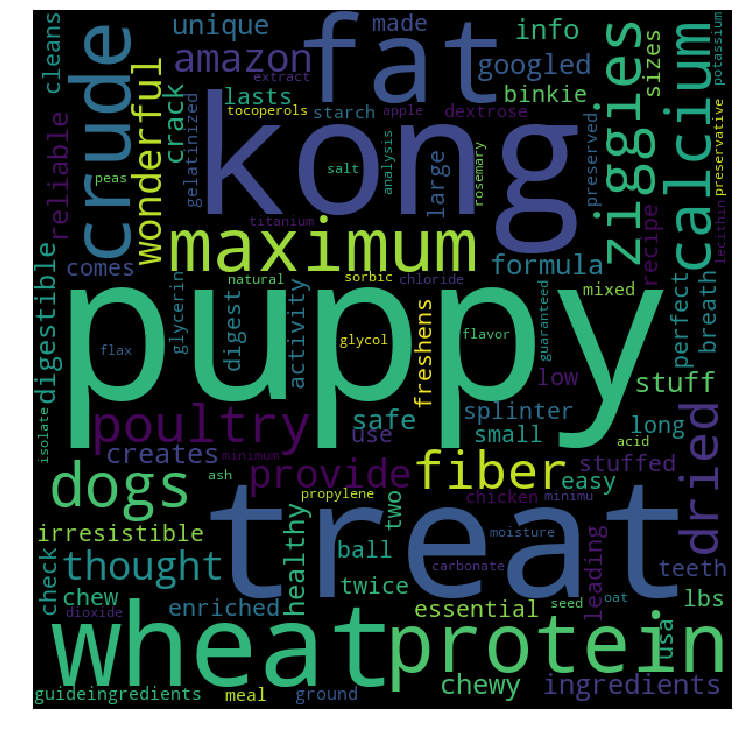

In [0]:
from wordcloud import WordCloud, STOPWORDS

count_features = count_vect.get_feature_names()
feature_importances = pd.DataFrame(labels,index = preprocessed_reviews, columns=['importance']).sort_values('importance',ascending=False)

feat_imp = feature_importances.iloc[0:1]

comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
        
        
        
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot                         
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include "Puppy" word and some of the frequent occuring words seem to be related with food products like"wheat", "protein" etc.

In [0]:
`

feat_imp = feature_importances.iloc[1:2]

comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
        
        
        
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot                       
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

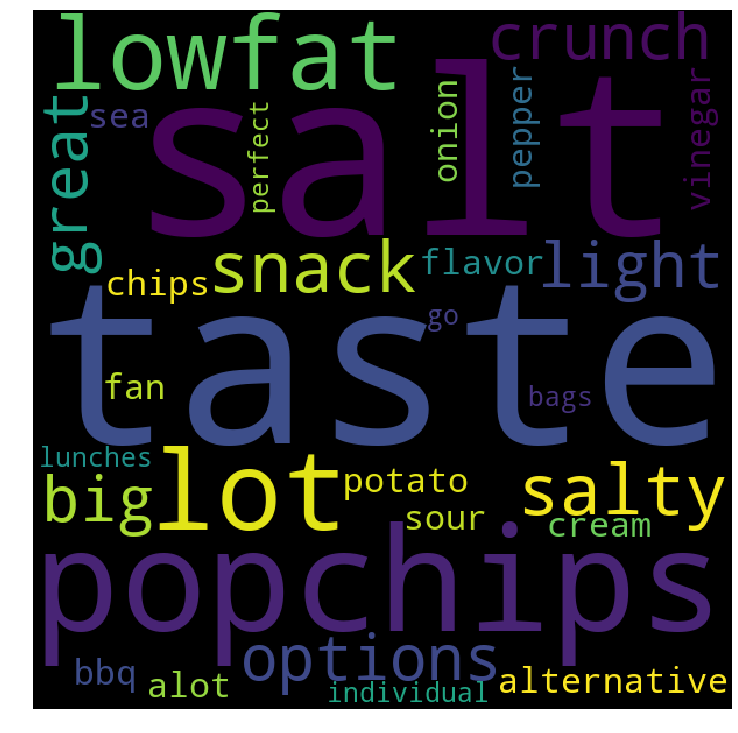

In [0]:
feat_imp = feature_importances.iloc[1:2]

comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
        
        
        
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot                       
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include "taste" word and some of the most occuring word seem to be from the food category like "chips","salt","snack" etc.





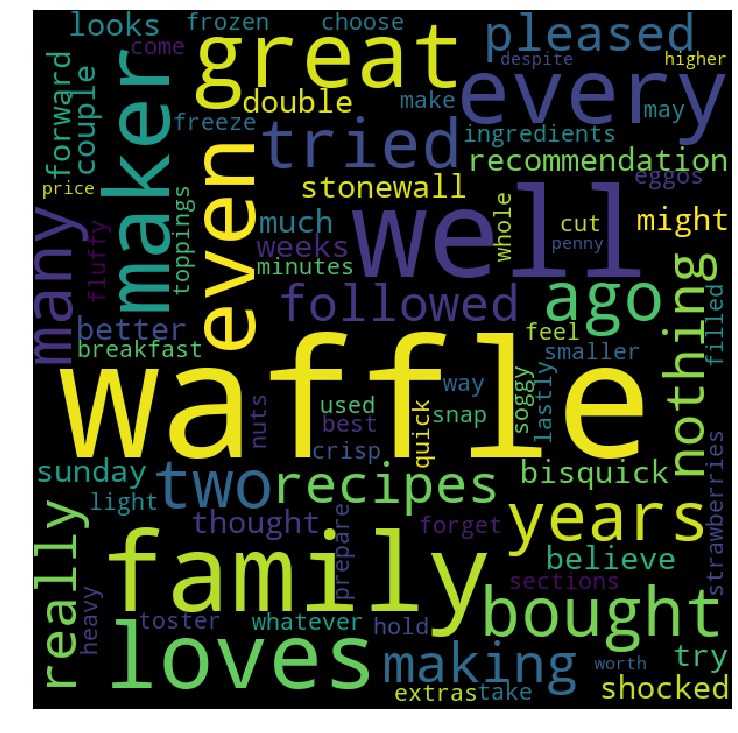

In [0]:
feat_imp = feature_importances.iloc[2:3]

comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
        
        
        
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot                       
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include "Waffle" word.We can interpret that from this wordcloud that positive words regarding food has been used like "well","pleased" etc.

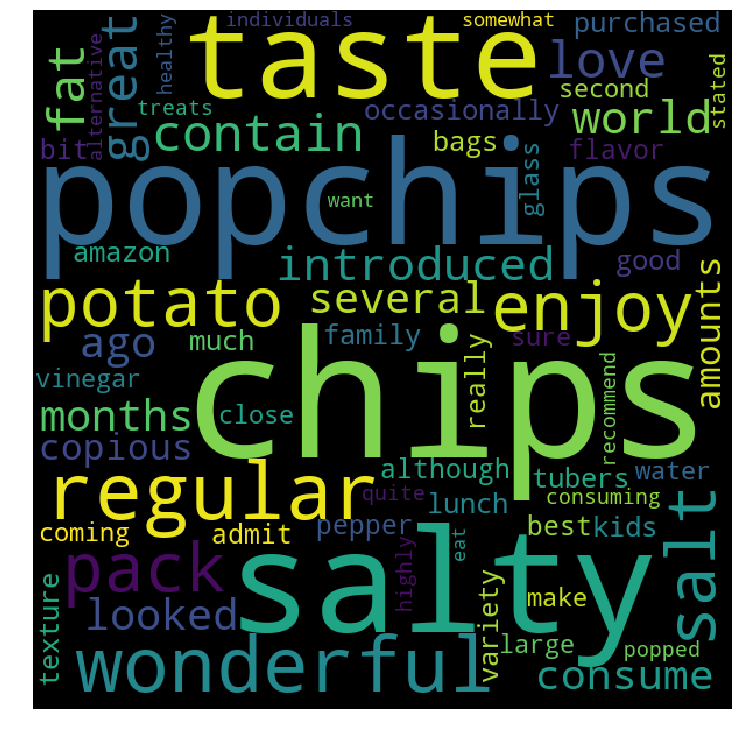

In [0]:
feat_imp = feature_importances.iloc[3:4]

comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
        
        
        
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot                       
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include "chips" word and some of the most occuring word seem to be from the food category like "chips","salt","potato" etc.





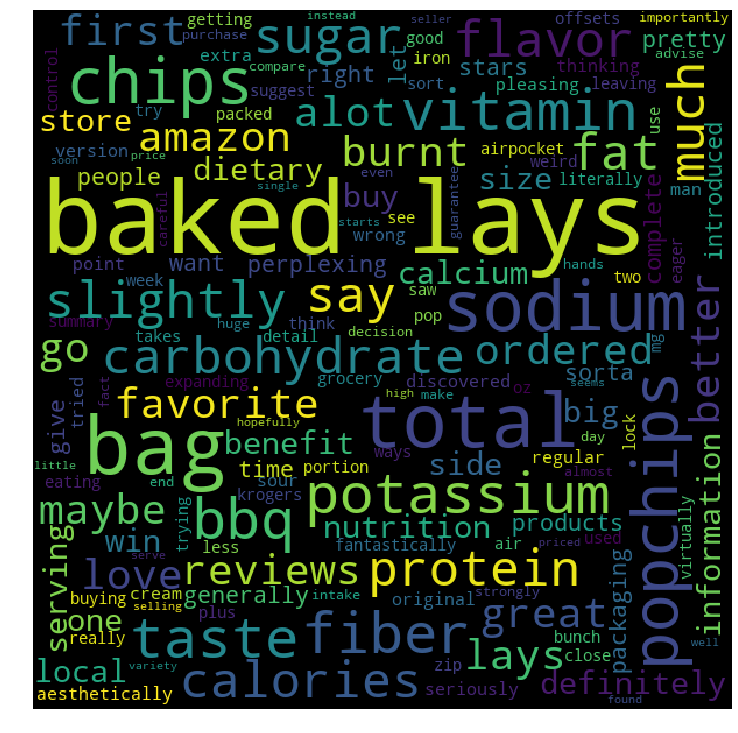

In [0]:
feat_imp = feature_importances.iloc[4:5]

comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
        
        
        
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot                       
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include "baked" word and clearly most of the words occuring frequently can be seen to be belonging to the food category.





## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able eat', 'able find', 'able get', 'able order', 'able use', 'absolute', 'absolute best']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (9564, 5765)
the number of unique words including both unigrams and bigrams  5765


In [0]:
X_test2 = tf_idf_vect.transform(X_test)

Text(0.5, 1.0, 'K vs Inertia')

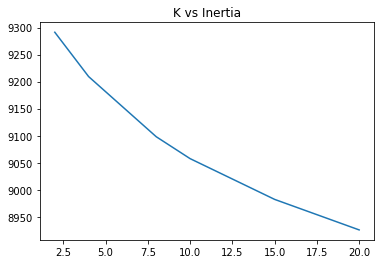

In [0]:
from sklearn.cluster import KMeans

errors=[]
k =[2,4,8,10,15,20]
for i in k :
    kmeans = KMeans(n_clusters=i, random_state=0, n_jobs=-1)
    kmeans.fit(final_tf_idf)
    pred=kmeans.predict(X_test2)
    errors.append(kmeans.inertia_)
    
plt.plot(k, errors)
plt.title("K vs Inertia")

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
model = KMeans(n_clusters=15, n_jobs=-1)
tf_data = tf_idf_vect.fit_transform(preprocessed_reviews)

model.fit(scaler.fit_transform(bow_data.toarray()))

labels = model.labels_

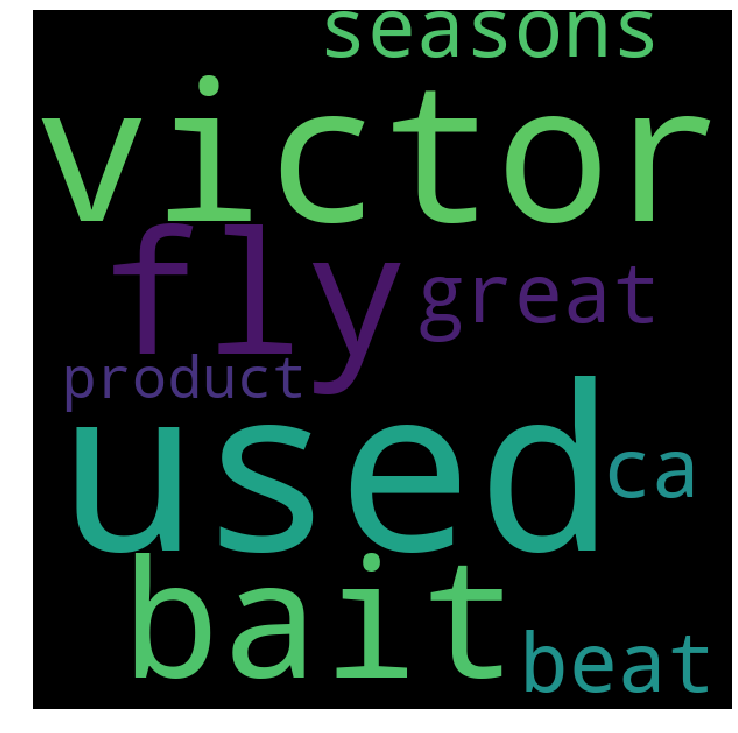

In [0]:
from wordcloud import WordCloud, STOPWORDS

count_features = tf_idf_vect.get_feature_names()
# w is the weight after fitting the model
feature_importances = pd.DataFrame(labels,index = preprocessed_reviews, columns=['importance']).sort_values('importance',ascending=False)

feat_imp = feature_importances.iloc[0:1]

comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
        
        
        
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include "victor" word.Since the number of words seem to be less,it is hard to see the common category in this wordcloud.




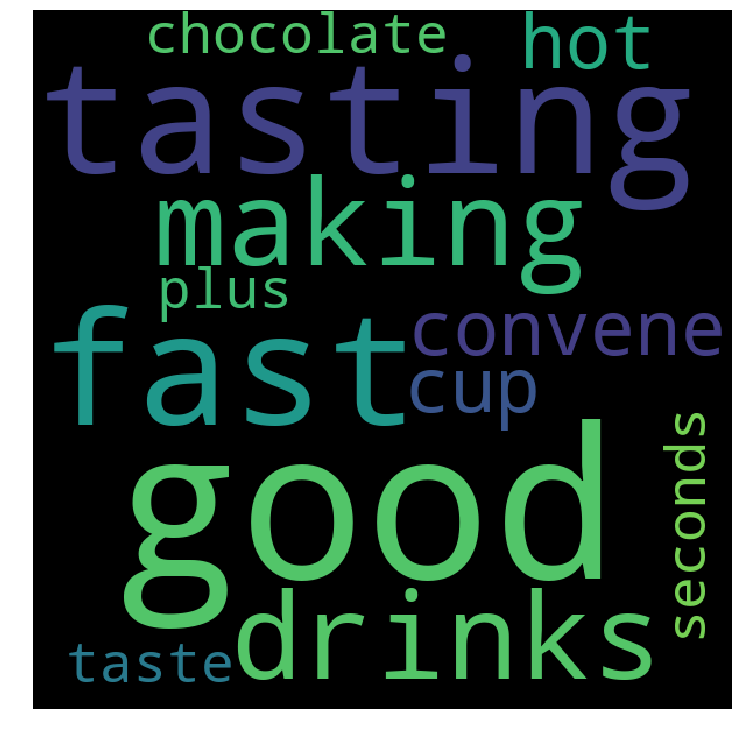

In [0]:
feature_importances = pd.DataFrame(labels,index = preprocessed_reviews, columns=['importance']).sort_values('importance',ascending=False)

feat_imp = feature_importances.iloc[1:2]

comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
        
        
        
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include "tasting" word.The words seem to be belonging to the beverage category.




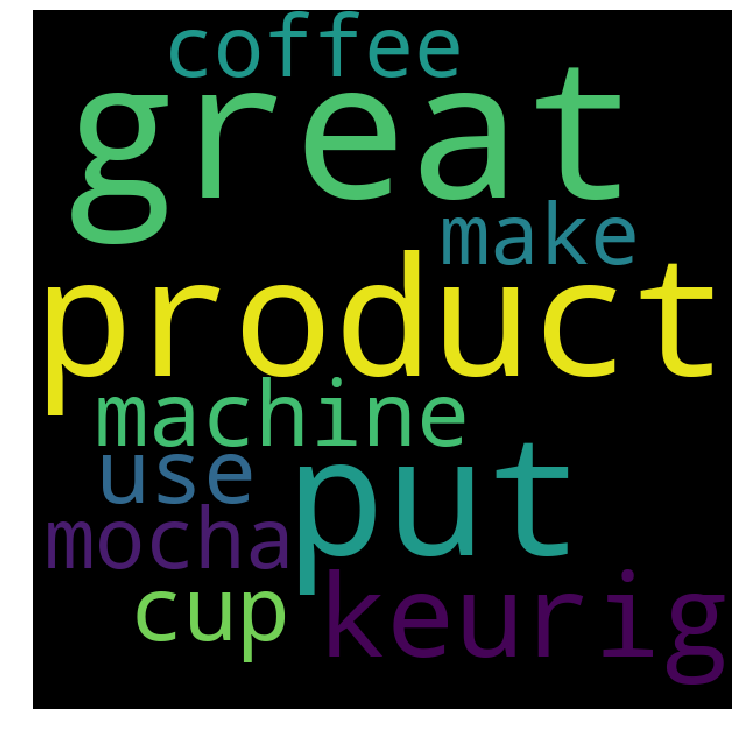

In [0]:
feature_importances = pd.DataFrame(labels,index = preprocessed_reviews, columns=['importance']).sort_values('importance',ascending=False)

feat_imp = feature_importances.iloc[2:3]

comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
        
        
        
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "great".Most of the words seem to be positive words in the beverage category.




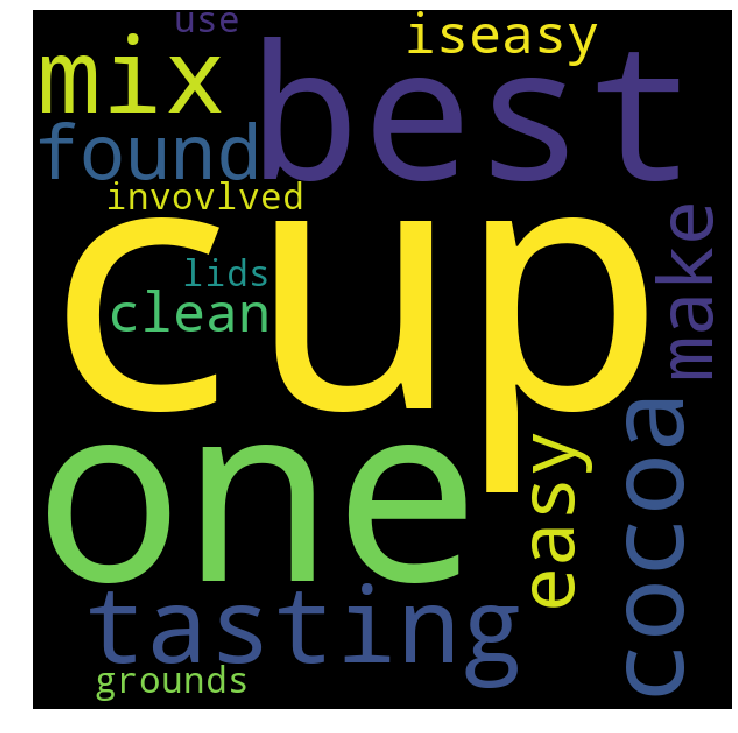

In [0]:
feature_importances = pd.DataFrame(labels,index = preprocessed_reviews, columns=['importance']).sort_values('importance',ascending=False)

feat_imp = feature_importances.iloc[3:4]

comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
        
        
        
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "cup".Most of the words seem to be positive reviews for beverage category.




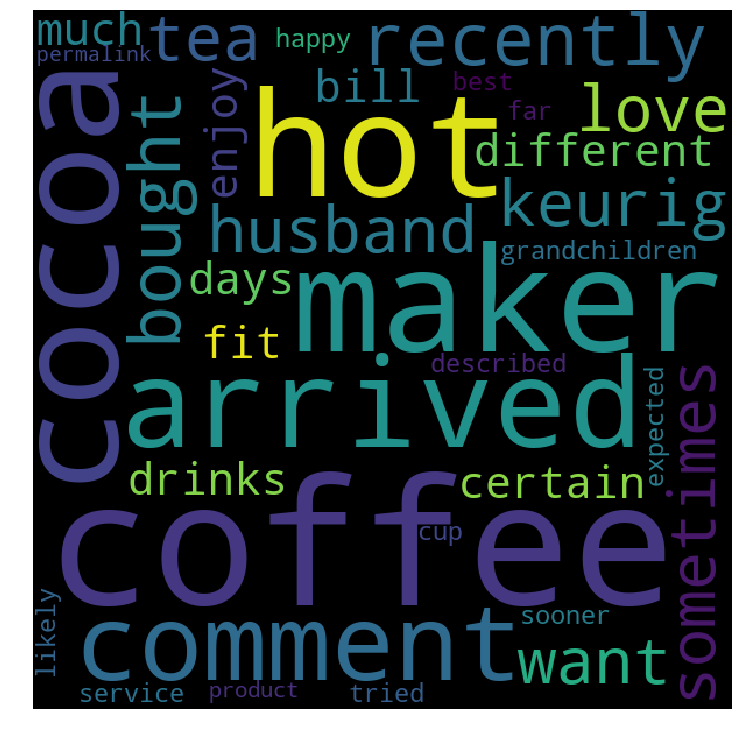

In [0]:
feature_importances = pd.DataFrame(labels,index = preprocessed_reviews, columns=['importance']).sort_values('importance',ascending=False)

feat_imp = feature_importances.iloc[4:5]

comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
        
        
        
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "hot" and "coffee".Most of the word seem to be used in the beverage category.




## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers = 4)
    print(w2v_model.wv.most_similar('good'))
    print('='*50)
    print(w2v_model.wv.most_similar('bad'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('pretty', 0.9160652756690979), ('think', 0.8950819969177246), ('really', 0.8862844705581665), ('quite', 0.8677381277084351), ('bummer', 0.8644355535507202), ('way', 0.862887442111969), ('surprised', 0.8518333435058594), ('describe', 0.8444761633872986), ('great', 0.8444739580154419), ('though', 0.8401960730552673)]
[('think', 0.9567855000495911), ('anything', 0.9440909028053284), ('though', 0.9284225106239319), ('something', 0.925248920917511), ('not', 0.9232605695724487), ('else', 0.9171139001846313), ('know', 0.9155355095863342), ('say', 0.9082108736038208), ('care', 0.9079498648643494), ('might', 0.9044976830482483)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5652
sample words  ['used', 'fly', 'bait', 'seasons', 'ca', 'not', 'beat', 'great', 'product', 'available', 'traps', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = [];
for sent in tqdm(X_train):
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

100%|██████████| 6694/6694 [01:48<00:00, 61.63it/s]


In [0]:
sent_vectors_test = [];
for sent in tqdm(X_test):
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent: #
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)

100%|██████████| 2870/2870 [00:46<00:00, 57.26it/s]


In [0]:
X_train3 = sent_vectors_train
X_test3 = sent_vectors_test

Text(0.5, 1.0, 'K vs Inertia')

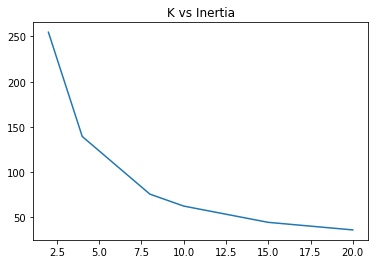

In [0]:
from sklearn.cluster import KMeans

errors=[]
k =[2,4,8,10,15,20]
for i in k :
    kmeans = KMeans(n_clusters=i, random_state=0, n_jobs=-1)
    kmeans.fit(X_train3)
    pred=kmeans.predict(X_test3)
    errors.append(kmeans.inertia_)
    
plt.plot(k, errors)
plt.title("K vs Inertia")

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
model = KMeans(n_clusters=7, n_jobs=-1)
count_data = count_vect.fit_transform(preprocessed_reviews)

model.fit(scaler.fit_transform(count_data.toarray()))

labels = model.labels_

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


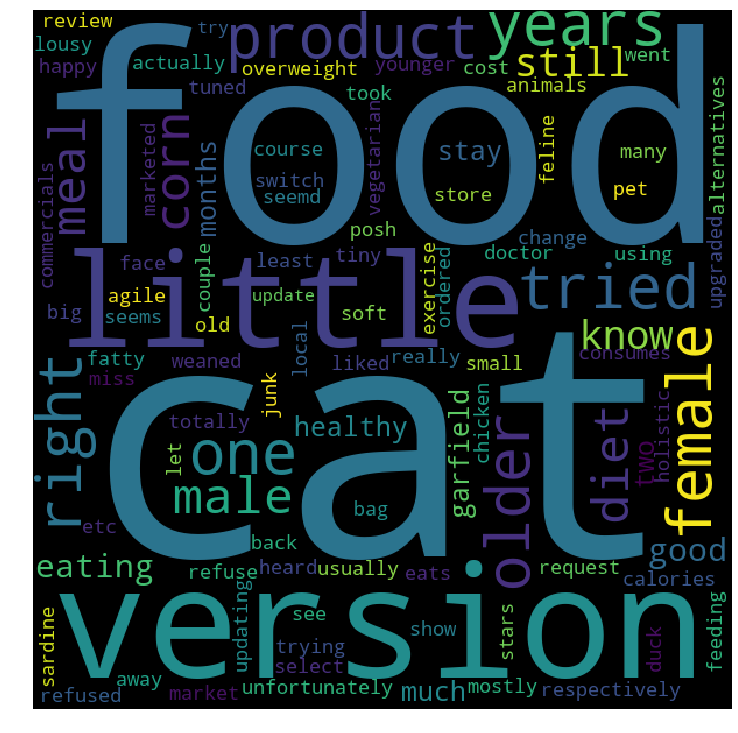

In [0]:
from wordcloud import WordCloud, STOPWORDS


feature_importances = pd.DataFrame(labels,index = preprocessed_reviews, columns=['importance']).sort_values('importance',ascending=False)

feat_imp = feature_importances.iloc[0:1]

comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
        
        
        
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "cat" and "food".Most of the words seem to be belonging to the pet food category.




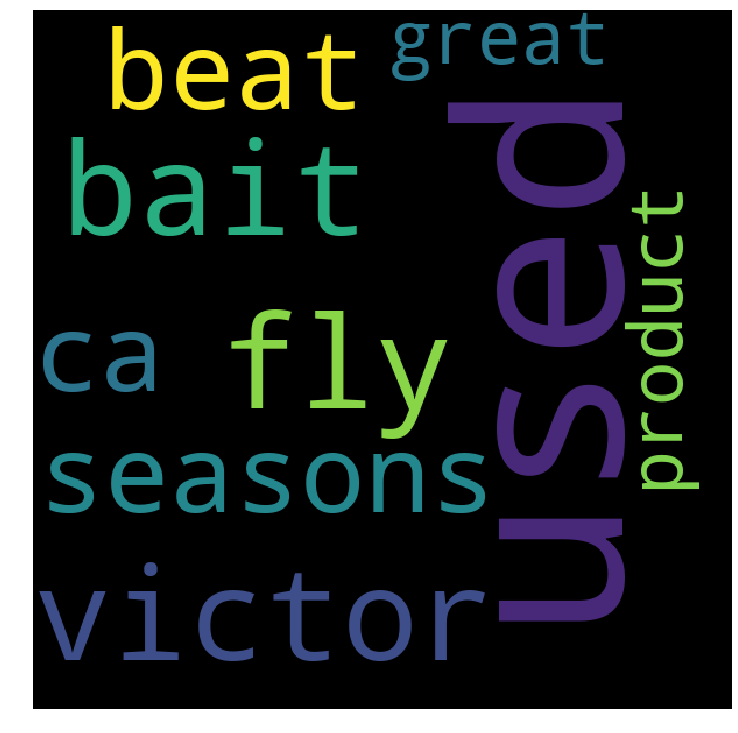

In [0]:
from wordcloud import WordCloud, STOPWORDS


feature_importances = pd.DataFrame(labels,index = preprocessed_reviews, columns=['importance']).sort_values('importance',ascending=False)

feat_imp = feature_importances.iloc[1:2]

comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
        
        
        
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "used".There are few words to derive a common category based on this wordcloud.




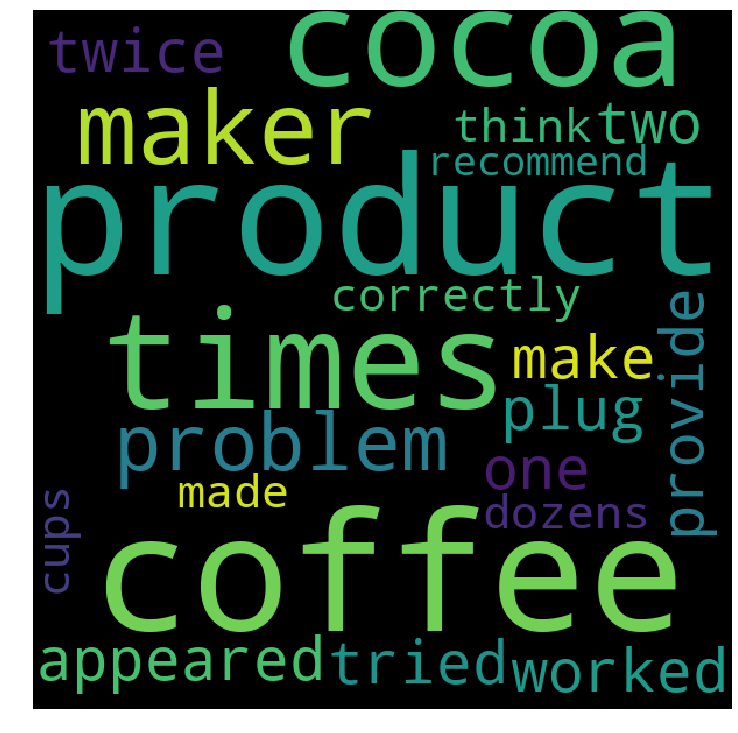

In [0]:
from wordcloud import WordCloud, STOPWORDS


feature_importances = pd.DataFrame(labels,index = preprocessed_reviews, columns=['importance']).sort_values('importance',ascending=False)

feat_imp = feature_importances.iloc[2:3]

comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
        
        
        
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "coffee","product".Most of the words seem to belong to beverage category.




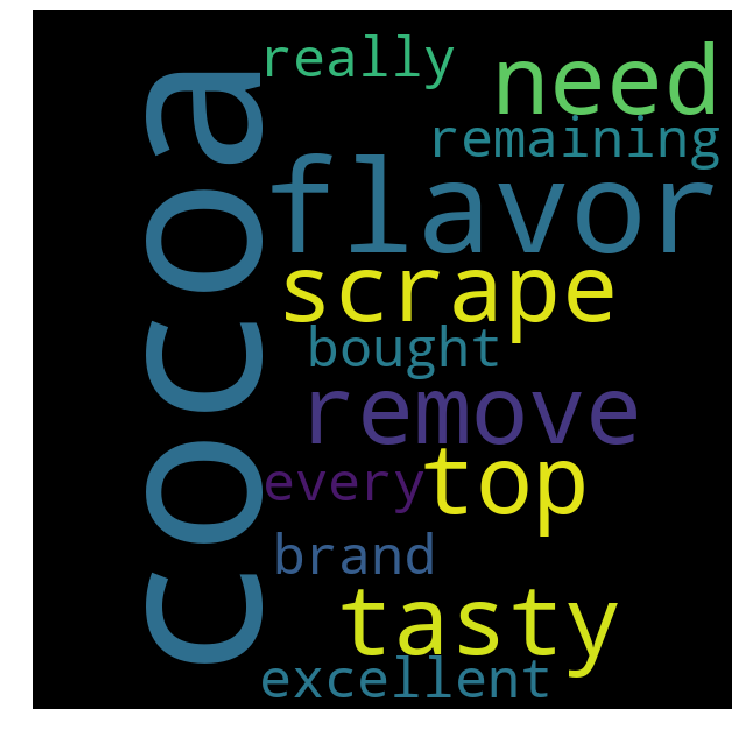

In [0]:
from wordcloud import WordCloud, STOPWORDS


feature_importances = pd.DataFrame(labels,index = preprocessed_reviews, columns=['importance']).sort_values('importance',ascending=False)

feat_imp = feature_importances.iloc[3:4]

comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
        
        
        
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "cocoa".Most of the words seem to belong to the beverage category with positive reactions.




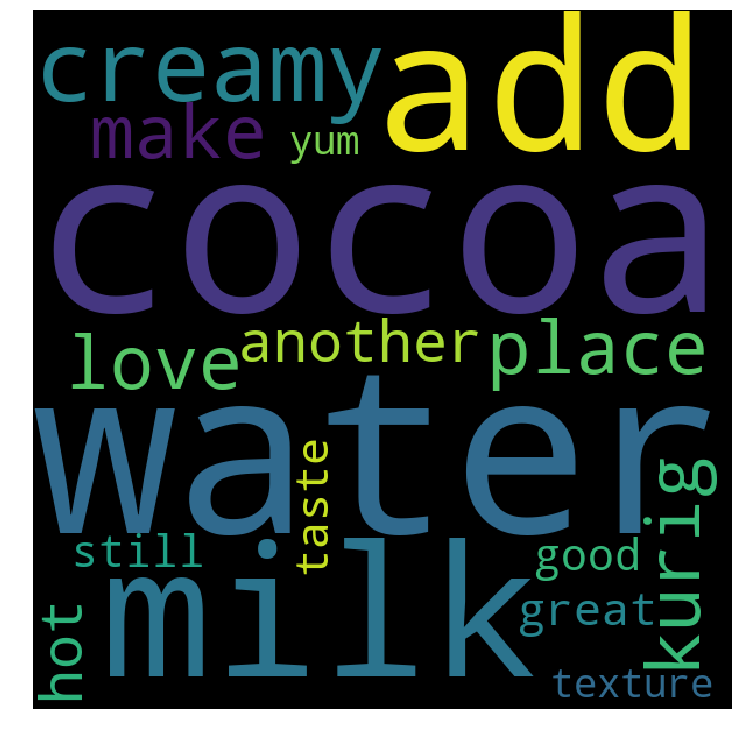

In [0]:
from wordcloud import WordCloud, STOPWORDS


feature_importances = pd.DataFrame(labels,index = preprocessed_reviews, columns=['importance']).sort_values('importance',ascending=False)

feat_imp = feature_importances.iloc[4:5]

comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
        
        
        
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "cocoa".Majority of the words are from drinks or beverage category.




#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
    
    
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = [];
for sent in tqdm(X_train):
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


In [0]:
#dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feat = model.get_feature_names() # tfidf words/col-names

tfidf_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_train):
    # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1

100%|██████████| 6694/6694 [05:03<00:00, 29.36it/s]


In [0]:
tfidf_test_vectors = []; 

row=0;
for sent in tqdm(X_test): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1

100%|██████████| 2870/2870 [02:11<00:00, 21.88it/s]


In [0]:
X_train4 = tfidf_train_vectors
X_test4 = tfidf_test_vectors

Text(0.5, 1.0, 'K vs Inertia')

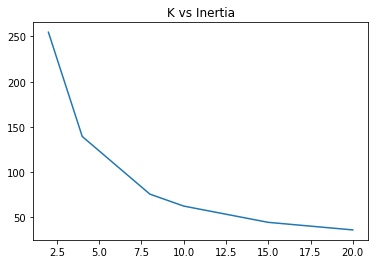

In [0]:
from sklearn.cluster import KMeans

errors=[]
k =[2,4,8,10,15,20]
for i in k :
    kmeans = KMeans(n_clusters=i, random_state=0, n_jobs=-1)
    kmeans.fit(X_train4)
    pred=kmeans.predict(X_test4)
    errors.append(kmeans.inertia_)
    
plt.plot(k, errors)
plt.title("K vs Inertia")

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
model = KMeans(n_clusters=8, n_jobs=-1)
tf_data = tf_idf_vect.fit_transform(preprocessed_reviews)

model.fit(scaler.fit_transform(tf_data.toarray()))

labels = model.labels_

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


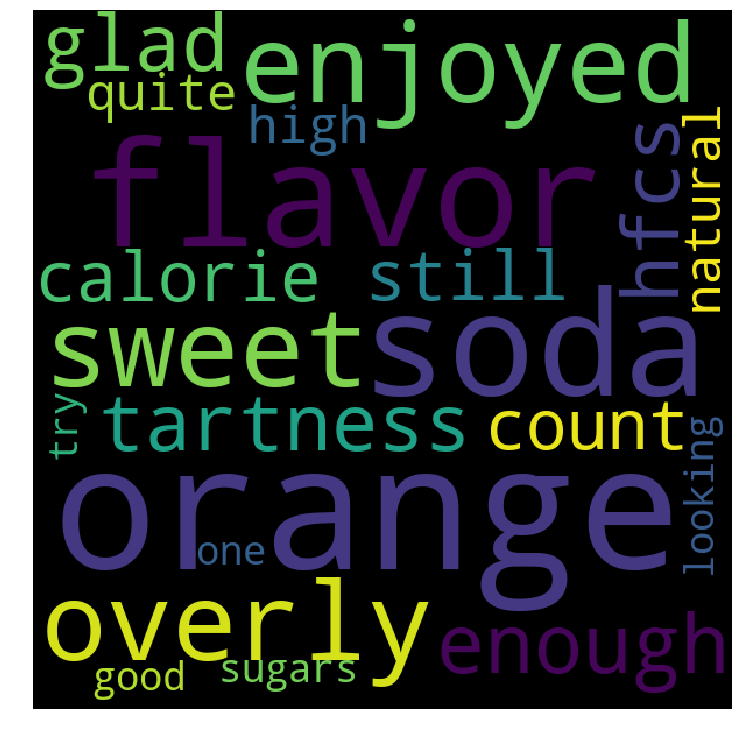

In [0]:
from wordcloud import WordCloud, STOPWORDS

count_features = tf_idf_vect.get_feature_names()
# w is the weight after fitting the model
feature_importances = pd.DataFrame(labels,index = preprocessed_reviews, columns=['importance']).sort_values('importance',ascending=False)

feat_imp = feature_importances.iloc[0:1]

comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
        
        
        
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "orange".Majority of the words seem to belong to the drinks category.




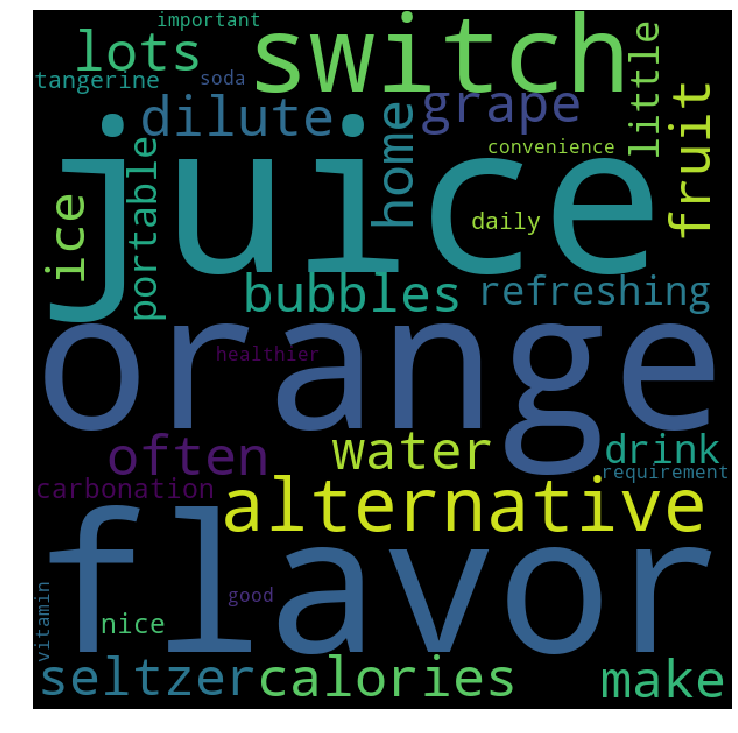

In [0]:
from wordcloud import WordCloud, STOPWORDS

count_features = tf_idf_vect.get_feature_names()
# w is the weight after fitting the model
feature_importances = pd.DataFrame(labels,index = preprocessed_reviews, columns=['importance']).sort_values('importance',ascending=False)

feat_imp = feature_importances.iloc[1:2]

comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
        
        
        
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "juice".Majority of the words seem to belong to the drinks category.




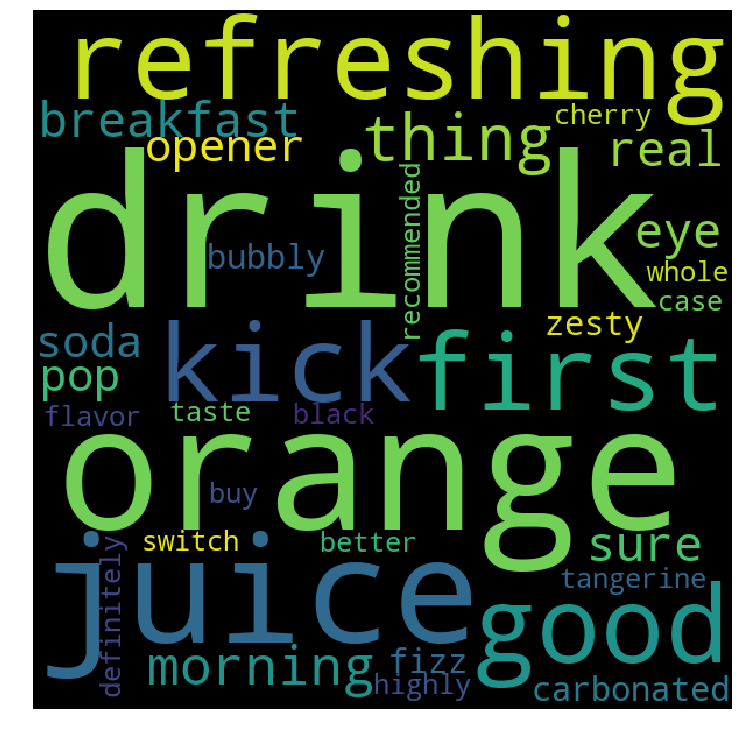

In [0]:
from wordcloud import WordCloud, STOPWORDS

count_features = tf_idf_vect.get_feature_names()
# w is the weight after fitting the model
feature_importances = pd.DataFrame(labels,index = preprocessed_reviews, columns=['importance']).sort_values('importance',ascending=False)

feat_imp = feature_importances.iloc[2:3]

comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
        
        
        
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "drink".Majority of the words seem to belong to the drinks category.




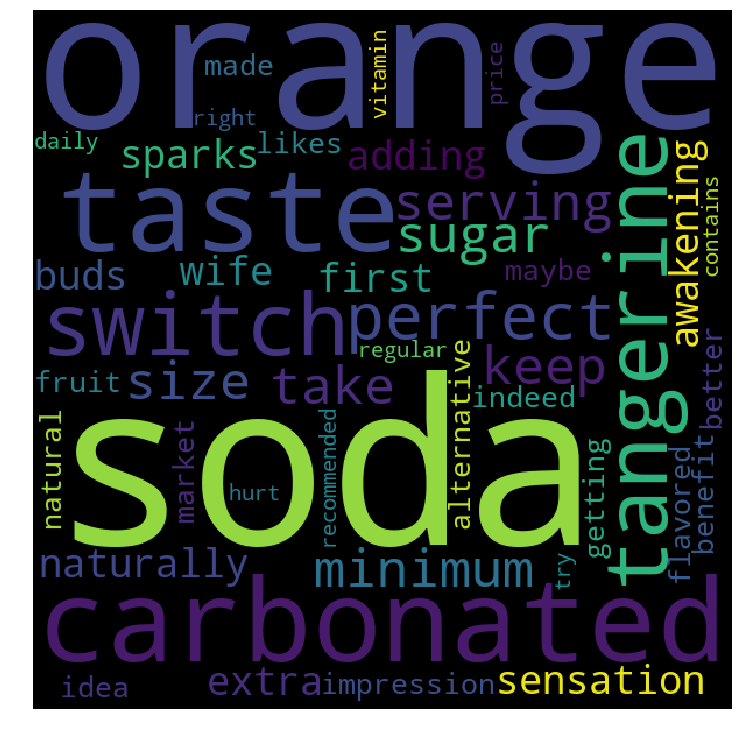

In [0]:
from wordcloud import WordCloud, STOPWORDS

count_features = tf_idf_vect.get_feature_names()
# w is the weight after fitting the model
feature_importances = pd.DataFrame(labels,index = preprocessed_reviews, columns=['importance']).sort_values('importance',ascending=False)

feat_imp = feature_importances.iloc[3:4]

comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
        
        
        
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "drink".Majority of the words seem to belong to the drinks category.




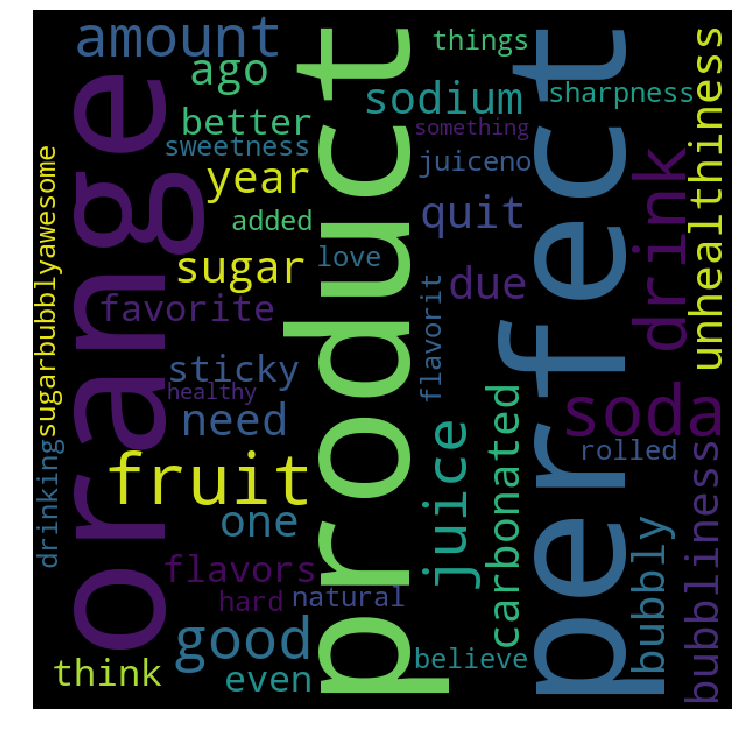

In [0]:
from wordcloud import WordCloud, STOPWORDS

count_features = tf_idf_vect.get_feature_names()
# w is the weight after fitting the model
feature_importances = pd.DataFrame(labels,index = preprocessed_reviews, columns=['importance']).sort_values('importance',ascending=False)

feat_imp = feature_importances.iloc[4:5]

comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
        
        
        
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "orange".Majority of the words seem to belong to the drinks category with most of the positive words.




## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

### Number of Clusters = 2

In [0]:
# Please write all the code with proper documentation
#X_train3 = sent_vectors_train
#X_test3 = sent_vectors_test

from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=2)
X_train5 = sent_vectors_train[:5000]
model.fit(scaler.fit_transform(X_train5))

label = model.labels_

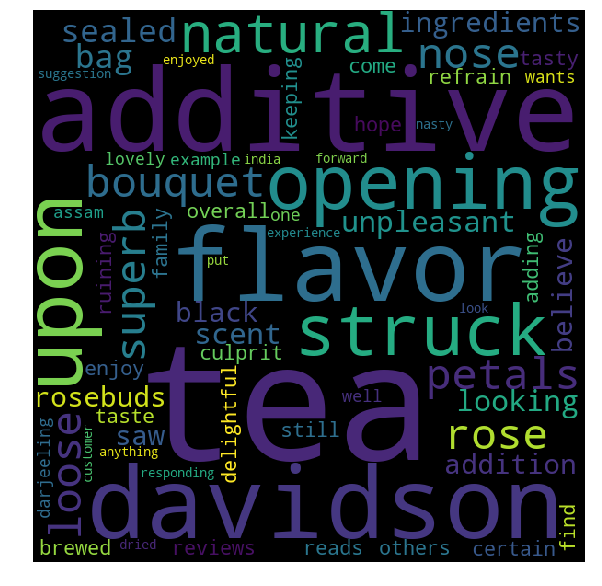

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[0:1]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "additive".Majority of the words seem to belong to the beverage category.




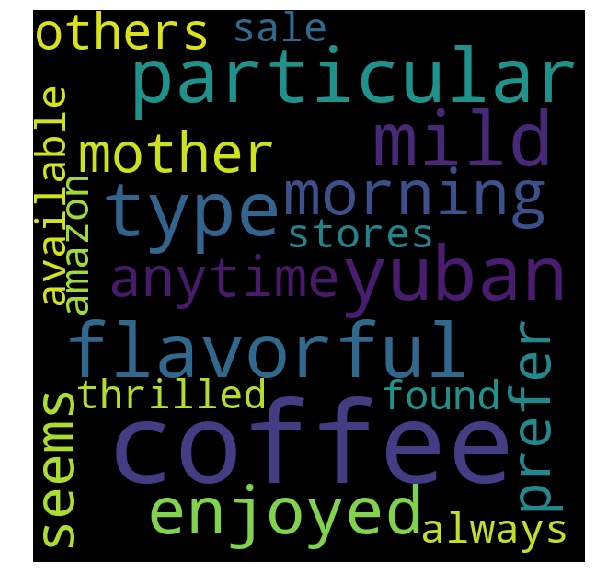

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[1:2]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "coffee".Majority of the words seem to belong to the beverage category.




### Number of Clusters = 5

In [0]:
# Please write all the code with proper documentation
#X_train3 = sent_vectors_train
#X_test3 = sent_vectors_test

from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=5)
X_train5 = sent_vectors_train[:5000]
model.fit(scaler.fit_transform(X_train5))

label = model.labels_

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

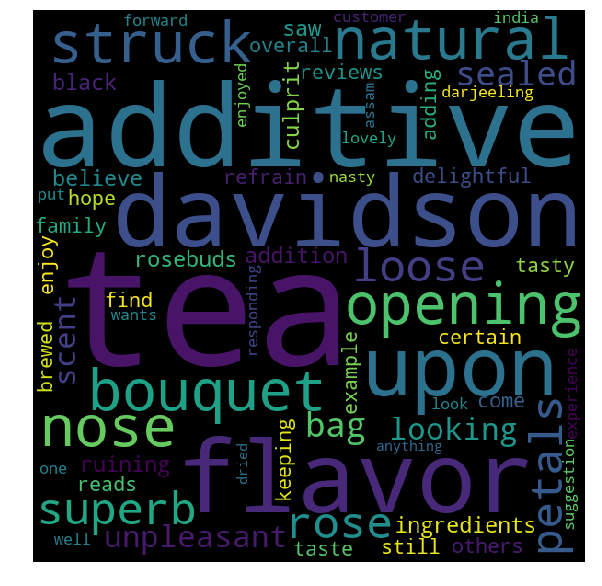

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[0:1]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "tea".Majority of the words seem to belong to the beverage category.




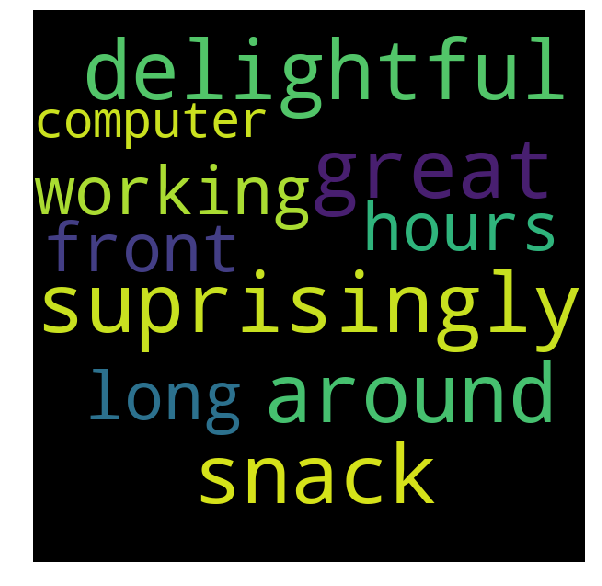

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[1:2]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "surprisingly".Few words exist to derive a common category.




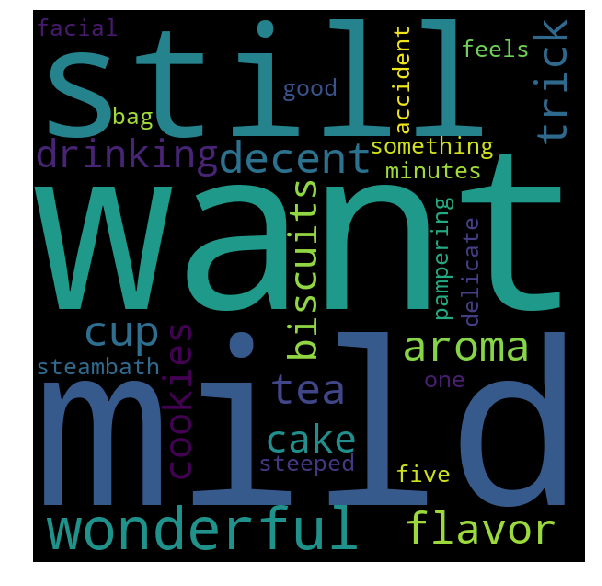

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[2:3]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "want" and "mild".Majority of the words seem to belong to the beverages category.




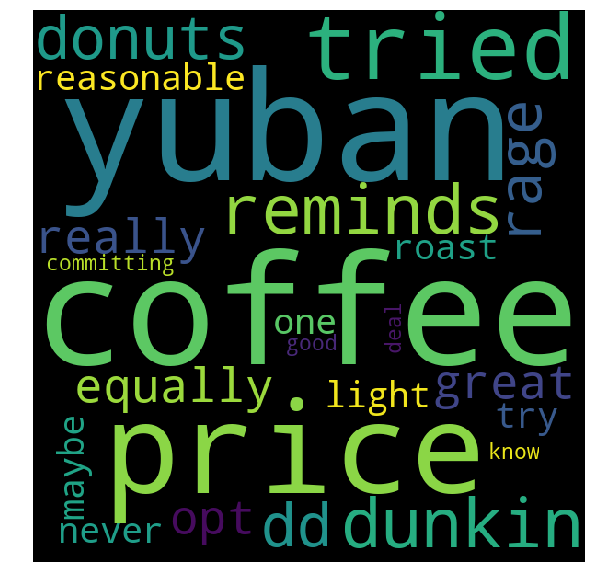

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[3:4]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "coffee".Majority of the words seem to belong to the beverages category.




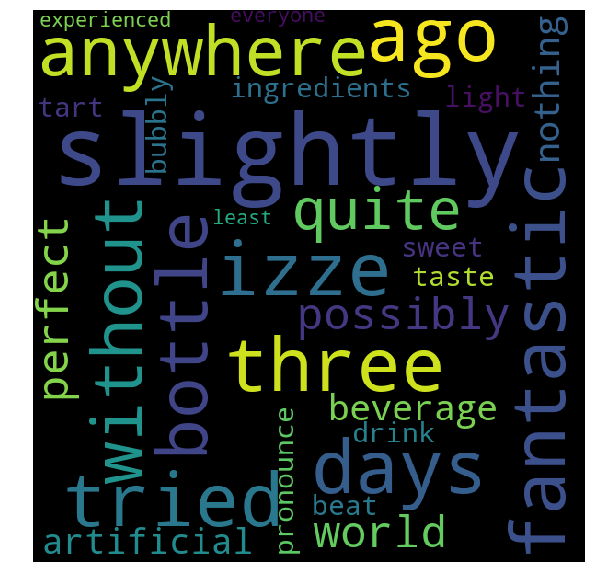

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[4:5]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "slightly".Majority of the words seem to belong to the beverages category.




### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

### Number of Clusters = 2

In [0]:
# Please write all the code with proper documentation
X_train4 = tfidf_train_vectors
X_test4 = tfidf_test_vectors


model = AgglomerativeClustering(n_clusters=2)
X_train5 = tfidf_train_vectors[0:5000]
model.fit(scaler.fit_transform(X_train5))
label = model.labels_

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

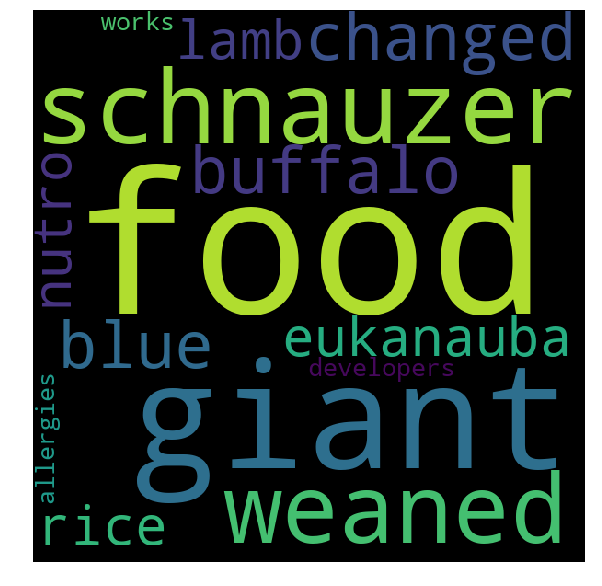

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[0:1]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "food". Majority of the words seem to belong to food category.



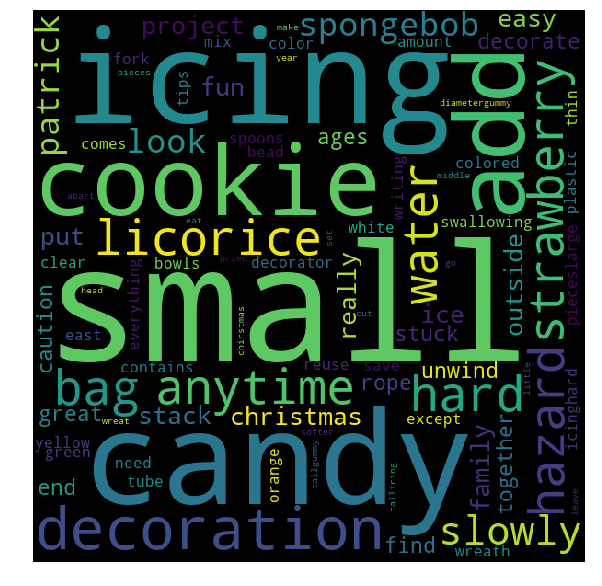

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[1:2]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "small".Majority of the words seem to belong to the food/fruits category.




### Number of clusters = 5

In [0]:
# Please write all the code with proper documentation
X_train4 = tfidf_train_vectors
X_test4 = tfidf_test_vectors


model = AgglomerativeClustering(n_clusters=5)
X_train5 = tfidf_train_vectors[0:5000]
model.fit(scaler.fit_transform(X_train5))
label = model.labels_

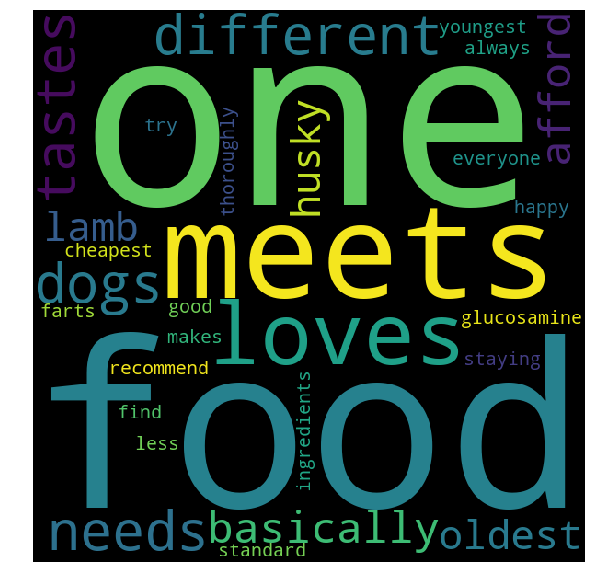

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[0:1]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "food".Majority of the words seem to belong to the pet-food category.




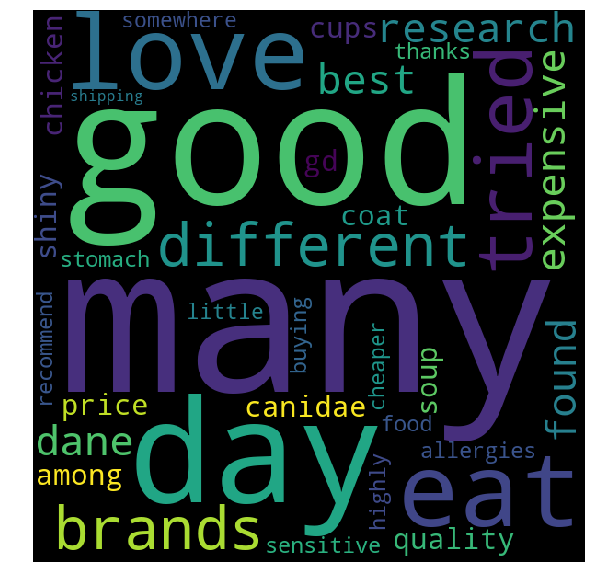

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[1:2]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "good".Majority of the words seem to be positive food reviews.




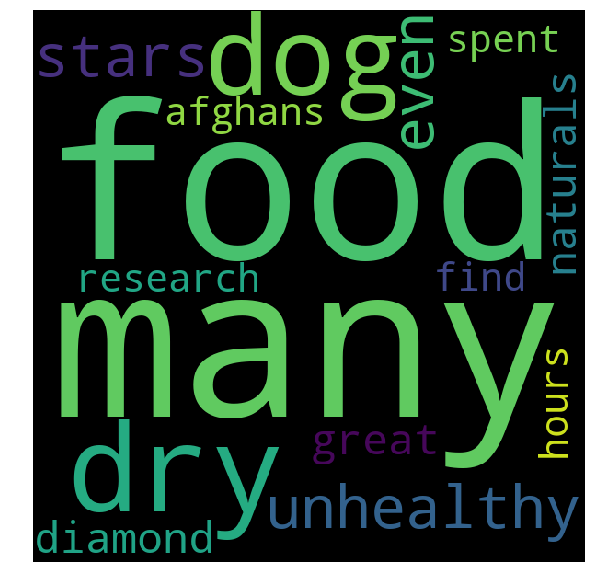

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[2:3]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "food".Majority of the words seem to belong to the pet-food category.




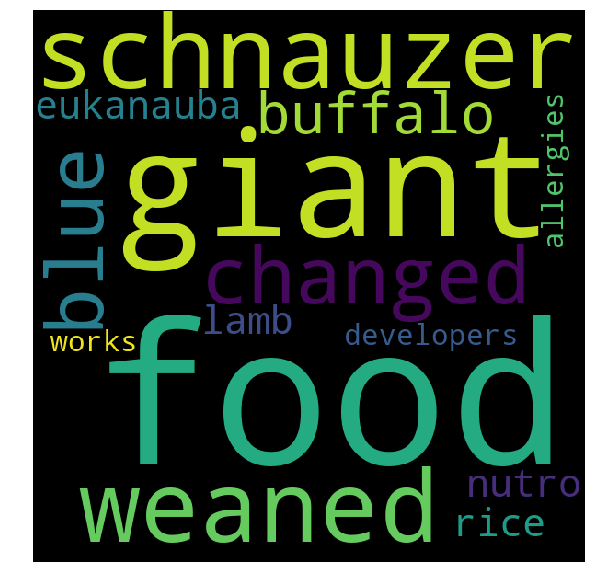

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[3:4]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "food".Majority of the words seem to belong to the pet-food category.




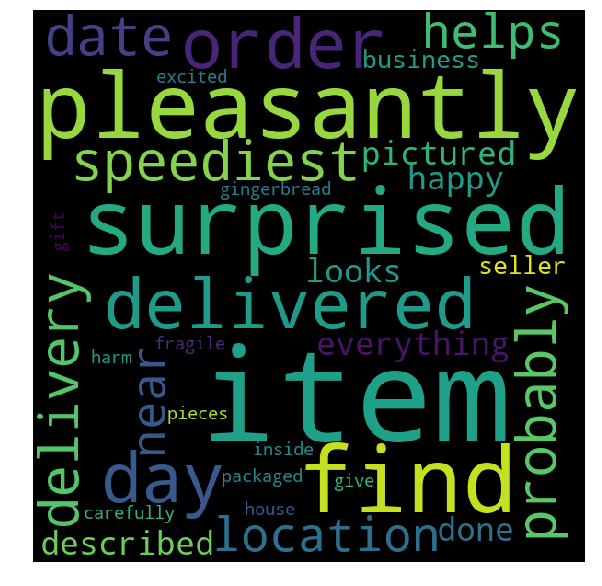

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[4:5]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "spleasantly".Majority of the words seem to be related to the delievery reviews by the users.




## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

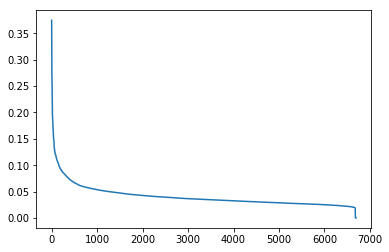

In [0]:
from sklearn.neighbors import NearestNeighbors

no_of_points = len(X_train)
ns = 15
nbrs = NearestNeighbors(n_neighbors=ns).fit(sent_vectors_train)
distances, indices = nbrs.kneighbors(sent_vectors_train)
distanceDec = sorted(distances[:,ns-1], reverse=True)
plt.plot(list(range(1,no_of_points+1)), distanceDec)


In [0]:
# Please write all the code with proper documentation
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=0.05)
model.fit(scaler.fit_transform(sent_vectors_train))
label = model.labels_

### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

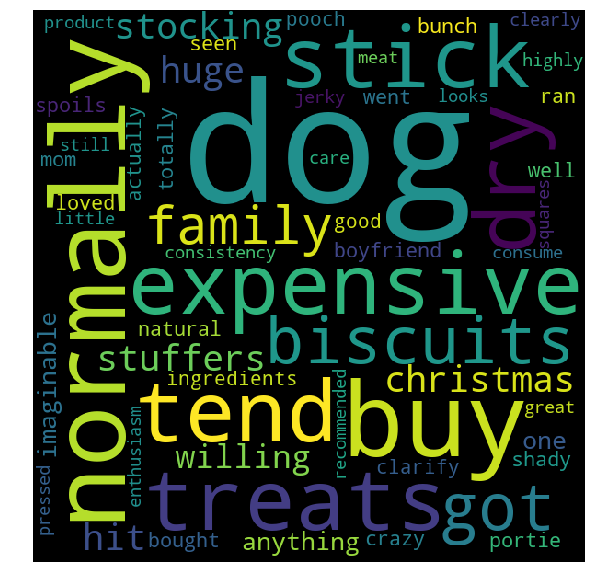

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[0:1]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "dog".Majority of the words seem to belong to the pet-food category.




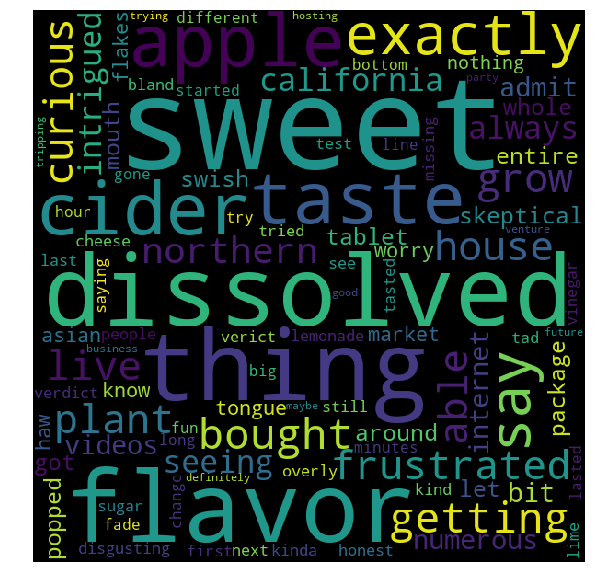

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[1:2]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "sweet".Majority of the words seem to belong to the food/fruit category.




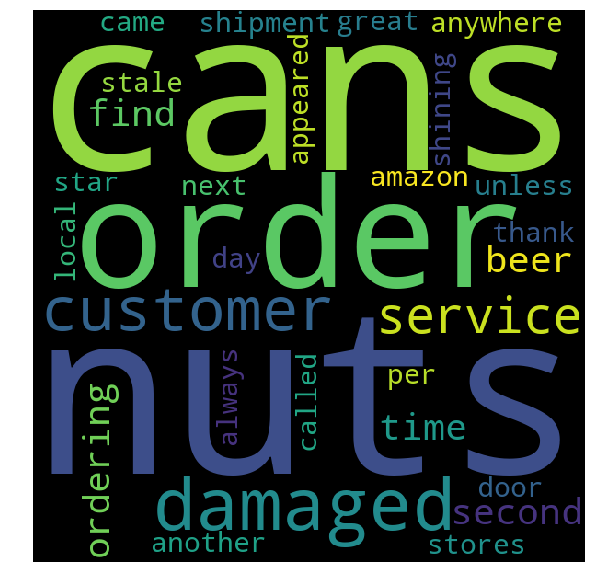

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[2:3]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "cans".Majority of the words seem to belong to the drinks or beverages category.




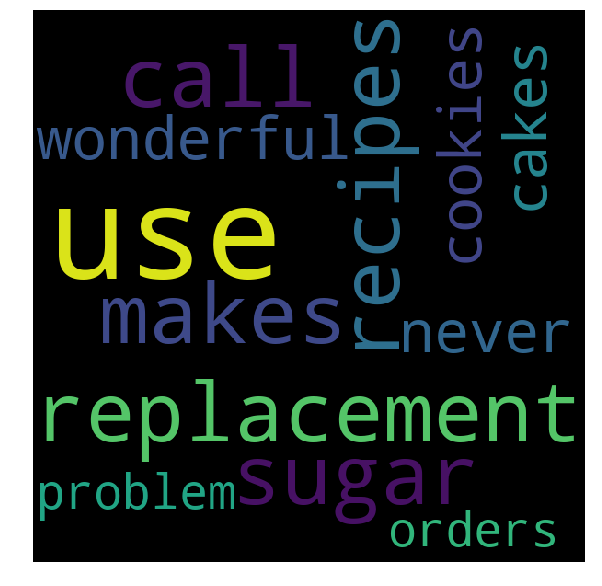

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[3:4]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "use".Majority of the words seem to belong to the food category.




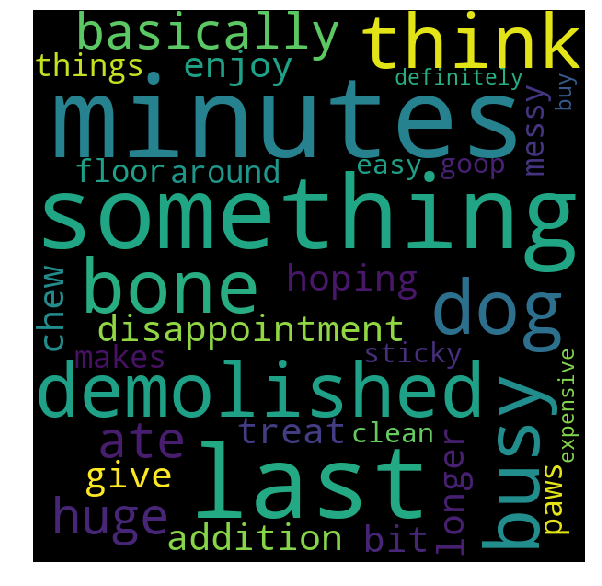

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[4:5]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "something".Majority of the words seem to belong to the pet-food category.




### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation
model = DBSCAN(eps=0.05)
model.fit(scaler.fit_transform(tfidf_train_vectors))
label = model.labels_

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

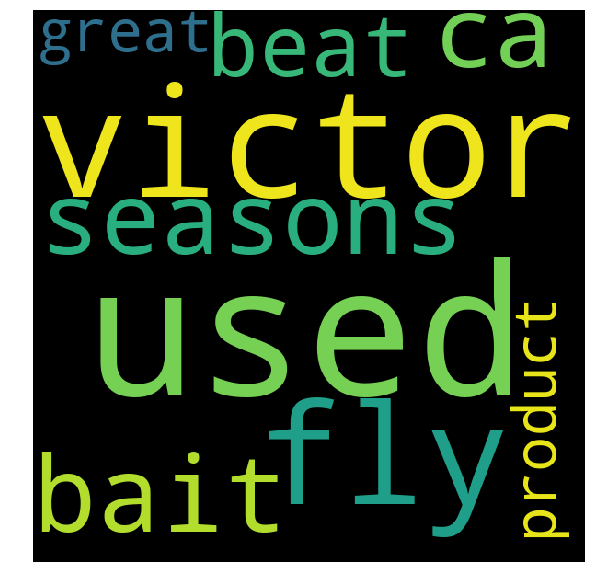

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[0:1]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "used".Few words to derive a common category.



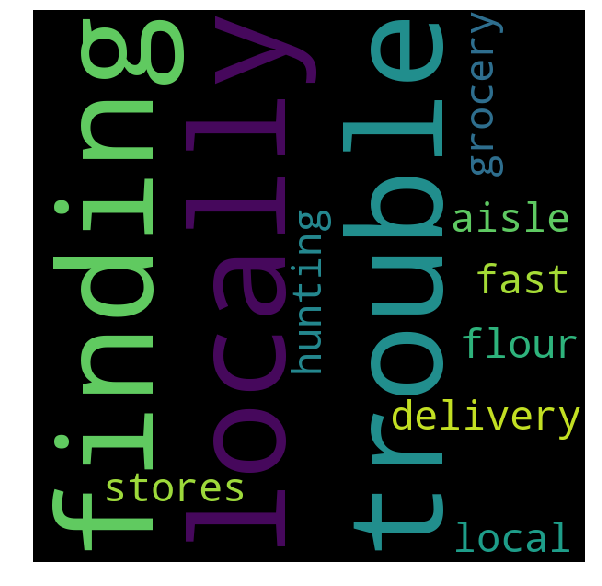

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[1:2]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "finding","locally" and "trouble".Majority of the words seem to be related to the delievery.




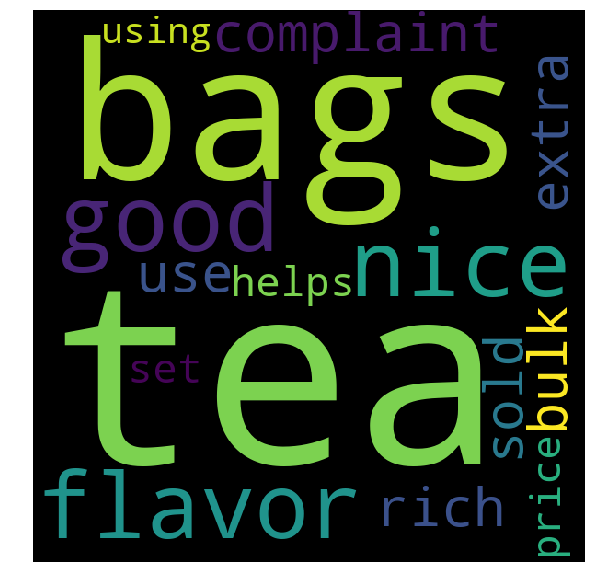

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[2:3]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "bags".Majority of the words seem to belong to the beverages category.




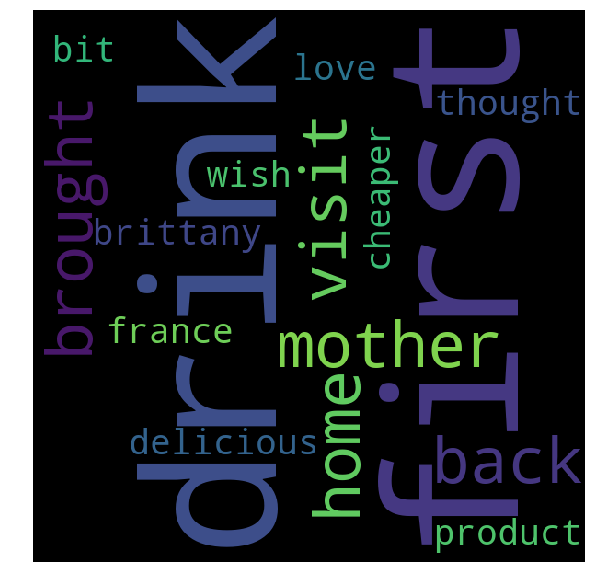

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[3:4]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "drink".Majority of the words seem to belong to the drinks category.




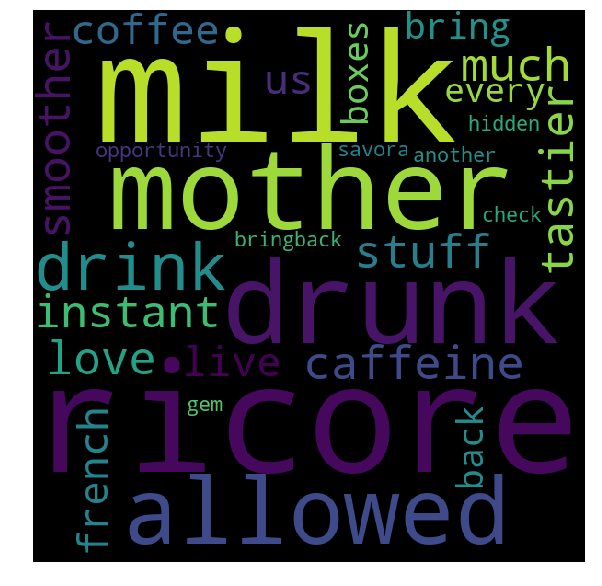

In [0]:
# Please write all the code with proper documentation

feature_importances = pd.DataFrame(label,index = preprocessed_reviews[:len(label)], columns=['importance']).sort_values('importance',ascending=False)
feat_imp = feature_importances.iloc[4:5]
comment_words = ' '
for val in feat_imp.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### From the above wordcloud,we can interpret that most of the reviews include the word "milk".Majority of the words seem to belong to the drinks or beverages category.




# [6] Conclusions

In [0]:
# Please write down few lines about what you observed from this assignment. 
# Also please do mention the optimal values that you obtained for number of components & number of clusters.

In [1]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Algorithm","Hyperparameter", "value"]

x.add_row(["DBSCAN",  'epsilon',0.05])
x.add_row(["Agglomerative Clustering",  'n_clusters',  5])
x.add_row(["K-Means(BOW)", 'n_clusters', 20])
x.add_row(["K-Means(TF-IDF)",'n_clusters',  15])
x.add_row(["K-Means(AVG-W2V)",'n_clusters',  7])
x.add_row(["K-Means(TF-IDF W2V)",'n_clusters',  8])





print(x)

+--------------------------+----------------+-------+
|        Algorithm         | Hyperparameter | value |
+--------------------------+----------------+-------+
|          DBSCAN          |    epsilon     |  0.05 |
| Agglomerative Clustering |   n_clusters   |   5   |
|       K-Means(BOW)       |   n_clusters   |   20  |
|     K-Means(TF-IDF)      |   n_clusters   |   15  |
|     K-Means(AVG-W2V)     |   n_clusters   |   7   |
|   K-Means(TF-IDF W2V)    |   n_clusters   |   8   |
+--------------------------+----------------+-------+
